In [0]:
### This is the code for decoding the bitplane version with eight GLS neuron
### Author: Harikrishnan NB
### Research Associate, National Institute of Advanced Studies

In [0]:
import numpy as np
import pandas as pd
from decimal import *
import math

In [0]:
def skew_tent(x,a,b,c):
  
    if x < b:
        xn = ((c - a)*x)/(b - a)
    else:
        xn = ((-(c-a)*(x-b))/(c - b)) + (c - a)
    return xn

## dec2bin

#no = 2
bits = 8

def dec2bin(no,bits):
    res = np.zeros((1,bits))
    k = -1
    for i in range(bits):
        if (no%2 == 0):

            res[0,k] = 0
        else:

            res[0,k] = 1
        k = k - 1
        no = (no - no%2) / 2
    dec2bin = res[0].astype(np.int)
    return dec2bin


def inv_skew_tent(num, a, b, c):
  j = 0
  for bit in num:
    if j ==0 and num[0] == 0:
      y = [a, b]
      val0 = np.multiply((b-a),y)/(c-a)
      val1 = np.multiply(-(c-b),y)/(c-a) + c
      out = np.array([val0, val1])
      for i in range(0,out.shape[0]):
        if out[i,0]>out[i,1]:
          temp = out[i,0]
          out[i,0] = out[i,1]
          out[i,1] = temp
      j = j+1
      y = out[bit]
    if j ==0 and num[0] == 1:
      y = [b, c]
      val0 = np.multiply((b-a),y)/(c-a)
      val1 = np.multiply(-(c-b),y)/(c-a) + c
      out = np.array([val0, val1])
      for i in range(0,out.shape[0]):
        if out[i,0]>out[i,1]:
          temp = out[i,0]
          out[i,0] = out[i,1]
          out[i,1] = temp
      j = j+1
      y = out[bit]
    
    elif j>=1:
      
      val0 = np.multiply((b-a),y)/(c-a)
      val1 = np.multiply(-(c-b),y)/(c-a) + c
      out = np.array([val0, val1])
      for i in range(0,out.shape[0]):
        if out[i,0]>out[i,1]:
          temp = out[i,0]
          out[i,0] = out[i,1]
          out[i,1] = temp
      j = j+1
      y = out[bit]

  return y

def in_v2bits(initial_val, bit_len,a,b,c):
  x = initial_val
  l =[]
  if x < b:
      l.append(0)
  elif x>= b:
      l.append(1)
  for i in range(0,bit_len -1):
    x = skew_tent(x,a,b,c)
    #print(x)
    if x < b:
      l.append(0)
    elif x>= b:
      l.append(1)
  return np.fliplr(np.array([l]))



def im_vec2binary_list(im_vec, bits):
  l = []
  for val in im_vec:
    l.append(dec2bin(val,bits))
  bit_value = []
  for arr in l:
    for val_arr in arr:
      bit_value.append(val_arr)
  return bit_value

def dec2bitplane(x, bits):
  # x is an image which is vectorized- row wise appended
  # imbit_array - a column of imbit will be from MSB to LSB of a single pixel. Where the last row represents the LSB
  imbit_array = np.zeros((bits, len(x))).astype(np.int)
  for j in range(0,len(x)):
    no = x[j]
    res = np.zeros((1,bits))
    k = -1
    for i in range(bits):
        if (no%2 == 0):

            imbit_array[k,j] = 0
        else:

            imbit_array[k,j] = 1
        k = k - 1
        no = (no - no%2) / 2
  return imbit_array


def in_bits2image(in_bits, bits, M, N):
  
  
  imlist = []
  batch_start =0
  batch_end = 8
  batch_size = bits
  while batch_end <= len(in_bits[0]):
    X = in_bits[0][batch_start:batch_end]
    reim = 0
    for k in range(0,bits):
              reim +=  X[k] * (2 ** (bits -1 - k))
    imlist.append(reim)
    
    batch_start += batch_size 
    
    batch_end += batch_size 
  image_r = np.array([imlist]).reshape(M,N)
  return image_r

def entropy(p):
  H = -(p * np.log2(p) + (1 - p) * np.log2(1 - p) )
  return H

def MSE(im, img_rec):
  (M,N)= im.shape
  mse = np.sum((im.astype(np.float) - img_rec.astype(np.float))**2)/float(M*N) 
  return mse

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
M = 128
N = 128
bits = 8
initial_val_file = open('/content/drive/My Drive/Coding Deep/Chaos/GLS Neuron Compression/data2/initial_val.txt', "r")
p_val_file =  open('/content/drive/My Drive/Coding Deep/Chaos/GLS Neuron Compression/data2/p_val.txt', "r")
initial_val_f = initial_val_file.read()
p_val_f = p_val_file.read()
#print(initial_val_f.read())



In [0]:
p_val_f_error = p_val_f.split('\n')[0:-1]

In [118]:
p_val_f_error

['0.613525390625',
 '0.696533203125',
 '0.60333251953125',
 '0.48052978515625',
 '0.498046875',
 '0.5057373046875',
 '0.49847412109375',
 '0.49578857421875']

In [119]:
p_val_f_error[-6]  =  0.234
print("The probability values affected by error",p_val_f_error)

The probability values affected by error ['0.613525390625', '0.696533203125', 0.234, '0.48052978515625', '0.498046875', '0.5057373046875', '0.49847412109375', '0.49578857421875']


In [0]:
## From initial value to bits
rec_bits = np.zeros((bits, M*N)).astype(np.int)
fsize = []
for i in range(0, bits):
  H = entropy(float(p_val_f_error[i]))
  bit_len = M*N
  getcontext().prec = math.ceil(M * N * H)
  fsize.append(math.ceil(M * N * H))
  b = Decimal(p_val_f_error[i])
  ## From initial value to bits
  a = Decimal(0)
  c = Decimal(1.0)
  in_v = Decimal(initial_val_f.split('\n')[0:-1][i])
  rec_bits[i,:] = in_v2bits(in_v, bit_len, a, b, c)

In [121]:
p_val_f

'0.613525390625\n0.696533203125\n0.60333251953125\n0.48052978515625\n0.498046875\n0.5057373046875\n0.49847412109375\n0.49578857421875\n'

In [0]:
pow2 = np.ones((8,1))
i = -1
for k in range(bits-1, -1,-1):
  i = i + 1
  pow2[i,0] = pow2[i,0] * (2**k) 
#np.ones((8, 1))

In [0]:
image = np.sum(np.multiply(pow2, rec_bits), axis = 0, keepdims = True).reshape(M,N).astype(np.uint8)

In [0]:
from PIL import Image
eim = Image.fromarray(image, 'L')
eim.save("/content/drive/My Drive/Coding Deep/Chaos/GLS Neuron Compression/data2/error_reconstructed_image_bitplane.png")

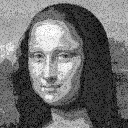

In [125]:
efile = Image.open("/content/drive/My Drive/Coding Deep/Chaos/GLS Neuron Compression/data2/error_reconstructed_image_bitplane.png")
efile


In [0]:
img_rec = np.array(efile)

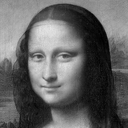

In [127]:

from PIL import Image
img = Image.open("/content/drive/My Drive/Coding Deep/Chaos/GLS Neuron Compression/data2/Mona_Lisa.png").convert('L')
#(M,N) = img.
img

In [0]:
im = np.array(img)
(M,N) = im.shape

In [129]:
mse =  MSE(im, img_rec)
print(" The Mean Squared Error is : ", mse)

 The Mean Squared Error is :  567.25


In [130]:
print("The File Size =", np.sum(fsize))

The File Size = 125041


In [131]:
print("PSNR = ", 20*np.log10(255.0/np.sqrt(mse)), "dB")

PSNR =  20.59305856310937 dB
